In [ ]:
# import tools
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statistics import mean
import json
import scipy.io
import os
import re
import math
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
sessions = ["0826_1000", "0825_1300", "0830_1300", "0819_1400",
    "0817_1000", "0831_1300", "0901_1300", "0827_1000", "0811_1000",
    "0920_1600", "0823_1400", "1005_1600", "0828_1300", #"0818_1000",
    "0816_1400", "0930_1700", "0917_1030", "0727_1400", "0928_1600",
    "0818_1600", "0802_1400", "0927_0930", "0915_1000", "0825_1000",
    "0824_1600", "0826_1300", "0813_1000", "0924_1000", "0806_1000",
    "0923_1000", "0901_1000", "0824_1000", "0831_1000", "0731_1000",
    "0923_1600", "0922_1000", "0924_1600", "0813_1600"];

In [ ]:
# For maintaineance conviniency, tools.py functions are laid out.
def get_report(session):
    report = open('/gdrive/My Drive/LCT data/try3/report.txt', 'r')
    desktop = None
    for line in report.readlines():
        if session in line:
            desktops = line.partition('desktop ')[-1]
            desktop = desktops.split(',')[:-1]
    if desktop is None:
        raise ValueError('Unable to fetch desktop information')

    return desktop

def eeg_all_timestamps():
    sessions = ["0826_1000", "0825_1300", "0830_1300", "0819_1400",
    "0817_1000", "0831_1300", "0901_1300", "0827_1000", "0811_1000",
    "0920_1600", "0823_1400", "1005_1600", "0828_1300", #"0818_1000",
    "0816_1400", "0930_1700", "0917_1030", "0727_1400", "0928_1600",
    "0818_1600", "0802_1400", "0927_0930", "0915_1000", "0825_1000",
    "0824_1600", "0826_1300", "0813_1000", "0924_1000", "0806_1000",
    "0923_1000", "0901_1000", "0824_1000", "0831_1000", "0731_1000",
    "0923_1600", "0922_1000", "0924_1600", "0813_1600"];

    all_timestamps = scipy.io.loadmat('/gdrive/My Drive/LCT data/try3/all_timestamps.mat')
    all_timestamps2 = scipy.io.loadmat('/gdrive/My Drive/LCT data/try3/all_timestamps2.mat')

    EEG_ALL_Timestamps = dict()
    for i in range(13):
        session_timestamps = dict()
        num_desktop = len(all_timestamps['all_timestamps'][0][i][1][0])
        for j in range(num_desktop):
            desktop = all_timestamps['all_timestamps'][0][i][1][0][j][0][0]
            timestamp = [float(all_timestamps['all_timestamps'][0][i][1][0][j][1][0]),
                         float(all_timestamps['all_timestamps'][0][i][1][0][j][2][0])]
            session_timestamps[desktop] = timestamp
        EEG_ALL_Timestamps[sessions[i]] = session_timestamps

    for i in range(24):
        session_timestamps = dict()
        num_desktop = len(all_timestamps2['all_timestamps'][0][i][1][0])
        for j in range(num_desktop):
            desktop = all_timestamps2['all_timestamps'][0][i][1][0][j][0][0]
            timestamp = [float(all_timestamps2['all_timestamps'][0][i][1][0][j][1][0]),
                         float(all_timestamps2['all_timestamps'][0][i][1][0][j][2][0])]
            session_timestamps[desktop] = timestamp
        EEG_ALL_Timestamps[sessions[13+i]] = session_timestamps

    return EEG_ALL_Timestamps

def eeg_timestamp(session, desktop):
    EEG_ALL_Timestamps = eeg_all_timestamps()
    for key in EEG_ALL_Timestamps.keys():
        if key == session:
            desktops = EEG_ALL_Timestamps[session]
            for value in desktops.keys():
                if value == "DESKTOP-" + desktop:
                    EEG_start_time = desktops[value][0]
                    EEG_end_time = desktops[value][1]
    return EEG_start_time, EEG_end_time

def load_data(session, desktop):
    '''
    Parameter: a string that specifies the session that we want to look at
    return: json_data and eeg_data corresponding to the session
    '''
    json_path = '/gdrive/My Drive/LCT data/json'
    eeg_path = '/gdrive/My Drive/LCT data/try3/processed'
    json_list = os.listdir(json_path)
    eeg_list = os.listdir(eeg_path)
    json_data = eeg_data = None

    for file in json_list:
        if session in file and desktop in file:
            json_data = json.load(open(os.path.join(json_path, file)))
    for file in eeg_list:
        if session in file and desktop in file:
            eeg_data = scipy.io.loadmat(os.path.join(eeg_path, file))['preprocessed_EEG']
    if json_data is None:
        raise ValueError('No behavioral data for session', session, ' or', desktop)
    if eeg_data is None:
        raise ValueError('No eeg data for session', session, ' or', desktop)
    # cropp eeg data
    eeg_first_timestamp, eeg_last_timestamp = eeg_timestamp(session, desktop)
    json_start_time = json_data['details']['initial timestamp']
    json_end_time = json_data['details']['final timestamp']
    if (abs(eeg_first_timestamp - json_start_time) > 10e-2) & (eeg_first_timestamp < json_start_time):
        init_offset = abs(eeg_first_timestamp - json_start_time)
        eeg_data = eeg_data[:20, round(init_offset*256):]
        print('Inital offset applied')
    else:
        print('No initial offset')
    if (abs(eeg_last_timestamp - json_end_time) > 10e-2) & (eeg_last_timestamp > json_end_time):
        end_offset = abs(eeg_last_timestamp - json_end_time)
        end = eeg_data.shape[1]
        eeg_data = eeg_data[:20, :round(end-end_offset*256)] # without timescroll
        print('End offset applied')
    else:
        print('No end offset')
    return json_data, eeg_data

def trial_timestamps_condition(json_data):
    init_timestamps = [] # 2sec before trial was presented
    end_timestamps = [] # 2sec after trial was presented
    gamble_number = []
    ambiguity = []
    condition = []
    num_trials = len(json_data['trials'])
    for i in range(num_trials):
        if len(json_data['trials'][i]['lct']) >= 3:
            # selecting 2sec before and after the initial stimuli is presented
            init_timestamps.append(json_data['trials'][i]['lct'][0]['time']+1)
            end_timestamps.append(json_data['trials'][i]['lct'][0]['time']+3)
            gamble_number.append(json_data['trials'][i]['lct'][0]['event']['parameters']['gamble']['gamble number'])
            ambiguity.append(json_data['trials'][i]['lct'][0]['event']['parameters']['gamble']['ambiguity'])
            condition.append(json_data['trials'][i]['lct'][0]['event']['parameters']['gamble']['condition'])
        else:
            gamble = json_data['trials'][i]['lct'][0]['event']['parameters']['gamble']['gamble number']
            trial = json_data['trials'][i]['lct'][0]['event']['parameters']['trial number']
            print('Trial', trial, 'gamble', gamble, 'not submitted at this round')
#     if (submission_timestamps - presented_timestamps < 10 for i in range(132)): print('Timestamps ready')
#     else: print('Error: Decision time exceeds 10 seconds.')

    return init_timestamps, end_timestamps, gamble_number, ambiguity, condition

def create_dataframe(session, desktop, json_data, eeg_data):
    json_start_time = json_data['details']['initial timestamp']
    init_timestamps, end_timestamps, gamble_number, ambiguity, condition = trial_timestamps_condition(json_data)
    eeg = []
    for i in range(132):
        start_idx = round(init_timestamps[i] - json_start_time) * 256
        end_idx = round(end_timestamps[i] - json_start_time) * 256
        trial_eeg = eeg_data[:, start_idx:end_idx]
        eeg.append(trial_eeg)

    result = {'desktop': [desktop] * 132,
              'session' : [session] * 132,
              'gamble number': gamble_number,
              'condition' : condition,
              'ambiguity' : ambiguity,
              'eeg' : eeg}

    return pd.DataFrame(result)

In [ ]:
# random_states = [109, 51, 111, 17, 172, 36, 223, 84]

In [ ]:
session = '1005_1600'
desktop = get_report(session)
desktop

['U9TEJGM', '9M4VCHG']

In [ ]:
json_data_1, eeg_data_1 = load_data(session, desktop[0])
json_data_2, eeg_data_2 = load_data(session, desktop[1])

No initial offset
End offset applied
No initial offset
End offset applied


In [ ]:
df_1 = create_dataframe(session, desktop[0], json_data_1, eeg_data_1)
df_2 = create_dataframe(session, desktop[1], json_data_2, eeg_data_2)
df = pd.concat([df_1, df_2])
df = df.reset_index()

Trial 1 gamble 20 not submitted at this round
Trial 1 gamble 63 not submitted at this round


In [ ]:
# if [df['eeg'][i].shape[1] == 512 for i in range(len(df))]:
#     print('shape matched')

In [ ]:
df_social = df[df['condition']=='social'].reset_index()
df_computer = df[df['condition']=='computer'].reset_index()

##### svm

In [ ]:
# train_test_split balance
# X_social = np.array([df_social['eeg'][i] for i in range(132)]).reshape(132, 10240)
# X_computer = np.array([df_computer['eeg'][i] for i in range(132)]).reshape(132, 10240)
# y_social = np.array([df_social['condition'][i] for i in range(132)])
# y_computer = np.array([df_computer['condition'][i] for i in range(132)])

In [ ]:
# svm
# acc = []
# svm_classifier = svm.SVC()
# for random_state in random_states:
#     X_train_social, X_test_social, y_train_social, y_test_social = train_test_split(X_social, y_social, test_size=0.3, random_state=random_state)
#     X_train_computer, X_test_computer, y_train_computer, y_test_computer = train_test_split(X_computer, y_computer, test_size=0.3, random_state=random_state)
#     X_train = np.concatenate((X_train_social, X_train_computer), axis=0)
#     y_train = np.concatenate((y_train_social, y_train_computer), axis=0)
#     X_test = np.concatenate((X_test_social, X_test_computer), axis=0)
#     y_test = np.concatenate((y_test_social, y_test_computer), axis=0)
#     svm_classifier.fit(X_train, y_train)
#     y_pred = svm_classifier.predict(X_test)
#     acc.append(metrics.accuracy_score(y_test, y_pred))

In [ ]:
# selecting 1-3 sec after wheels appeared on screen
# mean(acc)

#### preprare data for EEGNet

For class balance sake, I split social/computer conditions seperately and then do concat + shuffle.

In [ ]:
def data_loader(df_social, df_computer, random_state):
  # separate computer/social
  X_social = np.array([df_social['eeg'][i] for i in range(132)])
  X_social = np.transpose(X_social, axes = (0,2,1))
  X_computer = np.array([df_computer['eeg'][i] for i in range(132)])
  X_computer = np.transpose(X_computer, axes = (0,2,1))
  y_social = np.zeros(len(X_social))
  y_computer = np.ones(len(X_computer))
  # train/val/test split
  X_train_social, X_test_social, y_train_social, y_test_social = train_test_split(X_social, y_social, test_size=0.4, random_state=random_state)
  X_train_computer, X_test_computer, y_train_computer, y_test_computer = train_test_split(X_computer, y_computer, test_size=0.4, random_state=random_state)
  X_val_social, X_test_social, y_val_social, y_test_social = train_test_split(X_test_social, y_test_social, test_size=0.5, random_state=random_state)
  X_val_computer, X_test_computer, y_val_computer, y_test_computer = train_test_split(X_test_computer, y_test_computer, test_size=0.5, random_state=random_state)
  # concate social/computer
  X_train = np.concatenate((X_train_social, X_train_computer), axis=0).reshape(158, 1, 512, 20)
  y_train = np.concatenate((y_train_social, y_train_computer), axis=0)
  X_val = np.concatenate((X_val_social, X_val_computer), axis=0).reshape(52, 1, 512, 20)
  y_val = np.concatenate((y_val_social, y_val_computer), axis=0)
  X_test = np.concatenate((X_test_social, X_test_computer), axis=0).reshape(54, 1, 512, 20)
  y_test = np.concatenate((y_test_social, y_test_computer), axis=0)
  # shuffle train/val/test sets
  train_indices = np.arange(X_train.shape[0])
  np.random.shuffle(train_indices)
  X_train = X_train[train_indices]
  y_train = y_train[train_indices]

  val_indices = np.arange(X_val.shape[0])
  np.random.shuffle(val_indices)
  X_val = X_val[val_indices]
  y_val = y_val[val_indices]

  test_indices = np.arange(X_test.shape[0])
  np.random.shuffle(test_indices)
  X_test = X_test[test_indices]
  y_test = y_test[test_indices]

  return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
# EEGNet: https://github.com/aliasvishnu/EEGNet/blob/master/EEGNet-PyTorch.ipynb
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.T = 120

        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 20), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)

        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)

        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))

        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # 4*2*32 is the output size from the last hidden layer for input_size=(512, 20)
        self.fc1 = nn.Linear(4*2*32, 1)


    def forward(self, x):
        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)

        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)

        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)

        # FC Layer
        x = x.contiguous()
        x = x.view(-1, 4*2*32)
        x = F.sigmoid(self.fc1(x))
        return x


model = EEGNet().cuda(0)
print(model.forward(Variable(torch.Tensor(np.random.rand(1, 1, 512, 20)).cuda(0))))

tensor([[0.9032]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
test_accuracy = []
train_accuracy = []
val_accuracy = []
for i in range(10):
  model = EEGNet().cuda(0)
  random_state = np.random.choice(80)
  X_train, X_val, X_test, y_train, y_val, y_test = data_loader(df_social, df_computer, random_state)
  criterion = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  batch_size = 32
  # num_epoch = 10
  predicted = []
  train_losses = []
  val_losses = []

  for epoch in range(16):
    model.train()
    total_train_loss = 0.0

    # Training
    for i in range(len(X_train)//batch_size-1):
      s = i*batch_size
      e = i*batch_size+batch_size
      inputs = torch.from_numpy(X_train[s:e])
      labels = torch.FloatTensor(np.array([y_train[s:e]]).T*1.0)
      # wrap them in Variable
      inputs, labels = Variable(inputs.cuda(0)), Variable(labels.cuda(0))
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      total_train_loss += loss.item()
    predicted = outputs.data.cpu().numpy()
    labels = torch.FloatTensor(np.array([y_train[s:e]]).T*1.0)
    train_accuracy.append(roc_auc_score(labels, np.round(predicted)))

    # Average training loss for the epoch
    avg_train_loss = total_train_loss / len(inputs)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
      inputs = torch.from_numpy(X_val)
      labels = torch.FloatTensor(np.array([y_val]).T*1.0)
      inputs, labels = Variable(inputs.cuda(0)), Variable(labels.cuda(0))
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_val_loss += val_loss.item()
      predicted = outputs.data.cpu().numpy()
      labels = torch.FloatTensor(np.array([y_val]).T*1.0)
      val_accuracy.append(roc_auc_score(labels, np.round(predicted)))

      # Average validation loss for the epoch
      avg_val_loss = total_val_loss / len(inputs)
      val_losses.append(avg_val_loss)

  # Test accuracy
  model.eval()
  with torch.no_grad():
    inputs = torch.from_numpy(X_test)
    labels = torch.FloatTensor(np.array([y_test]).T*1.0)
    inputs, labels = Variable(inputs.cuda(0)), Variable(labels.cuda(0))
    outputs = model(inputs)
    predicted = outputs.data.cpu().numpy()
    labels = torch.FloatTensor(np.array([y_test]).T*1.0)
    test_accuracy.append(roc_auc_score(labels, np.round(predicted)))

In [ ]:
max(val_accuracy), max(train_accuracy), max(test_accuracy)

(0.6346153846153846, 0.8809523809523809, 0.6111111111111112)

In [ ]:
dic = ['lr = 0.001': (0.673076923076923, 0.8319838056680162, 0.5185185185185185),
       'lr = 0.002': (0.5961538461538461, 0.8166666666666668, 0.5740740740740741),
       'lr = 0.005': (0.6346153846153846, 0.9, 0.5555555555555556)
       'lr = 0.01': (0.6538461538461537, 0.7301587301587301, 0.5925925925925926),
       'lr = 0.05': (0.6346153846153847, 0.746031746031746, 0.5740740740740741),
       'lr = 0.1': (0.6153846153846154, 0.7619047619047621, 0.5370370370370371)]

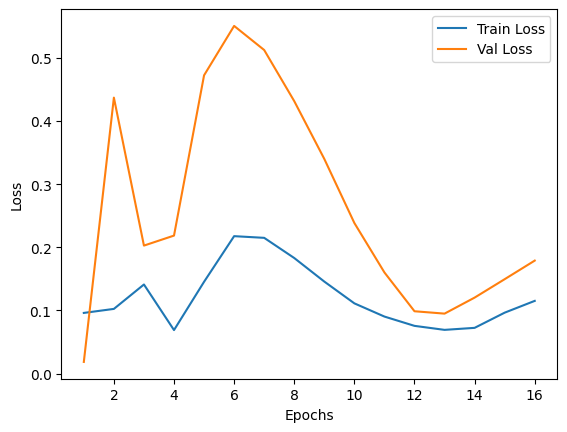

In [ ]:
plt.plot(range(1, 17), train_losses, label='Train Loss')
plt.plot(range(1, 17), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01)
# batch_size = 16
# num_epoch = 16
# predicted = []
# train_losses = []
# val_losses = []

# for epoch in range(16):
#   model.train()
#   total_train_loss = 0.0

#   # Training
#   for i in range(len(X_train)//batch_size-1):
#     s = i*batch_size
#     e = i*batch_size+batch_size
#     inputs = torch.from_numpy(X_train[s:e])
#     labels = torch.FloatTensor(np.array([y_train[s:e]]).T*1.0)
#     # wrap them in Variable
#     inputs, labels = Variable(inputs.cuda(0)), Variable(labels.cuda(0))
#     outputs = model(inputs)
#     loss = criterion(outputs, labels)
#     loss.backward()
#     optimizer.step()
#     total_train_loss += loss.item()

#   # Average training loss for the epoch
#   avg_train_loss = total_train_loss / len(inputs)
#   train_losses.append(avg_train_loss)

#   # Validation
#   model.eval()
#   total_val_loss = 0.0

#   with torch.no_grad():
#     inputs = torch.from_numpy(X_val)
#     labels = torch.FloatTensor(np.array([y_val]).T*1.0)
#     inputs, labels = Variable(inputs.cuda(0)), Variable(labels.cuda(0))
#     outputs = model(inputs)
#     val_loss = criterion(outputs, labels)
#     total_val_loss += val_loss.item()

#     # Average validation loss for the epoch
#     avg_val_loss = total_val_loss / len(inputs)
#     val_losses.append(avg_val_loss)

#### Power spectrum analysis

In [ ]:
eeg_data_1[0].shape

(190587,)

In [ ]:
from scipy.signal import welch

sampling_rate = 256  # Replace this with your actual sampling rate
# Define the frequency bands
frequency_bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 40)
}

# Compute the power spectral density (PSD) using Welch method
frequencies, power_spectrum = welch(eeg_data_1[0], fs=sampling_rate)

# # Plot the original EEG signal
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(np.arange(len(eeg_data_1)) / sampling_rate, eeg_data_1)
# plt.title('Original EEG Signal')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')

# # Plot the power spectral density
# plt.subplot(2, 1, 2)
# plt.plot(frequencies, 10 * np.log10(power_spectrum))
# plt.title('Power Spectral Density (PSD)')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power/Frequency (dB/Hz)')
# plt.xlim(0, 40)  # Set the frequency range for better visualization
# plt.tight_layout()
# plt.show()

## Extract power in each frequency band
# band_powers = {}
# for band, (low, high) in frequency_bands.items():
#     indices = np.where((frequencies >= low) & (frequencies <= high))
#     band_power = np.trapz(10 ** (power_spectrum[indices] / 10), frequencies[indices])
#     band_powers[band] = band_power

# # Print the band powers
# print("Band Powers:")
# for band, power in band_powers.items():
#     print(f"{band}: {power} uV^2/Hz")